In [ ]:
!pip install wandb
!pip3 install pytorch_lightning torchmetrics

In [ ]:
# Возможно ниже будет не очень работать WandbLogger с первого разу, перезапустите kernel тетрадки
import wandb

wandb.login(key='962da58921d6ba76bb212bdbb3d2cfd9f1dce121')

In [3]:
import math
import os
import random
import sys

import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import torch
import torchvision
from torchvision import models
import torchvision.transforms as transforms
from PIL import Image
from pytorch_lightning.loggers import WandbLogger
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchmetrics.functional import accuracy
from torchvision.datasets import ImageFolder
from tqdm import tqdm

# You may add any imports you need

In [4]:
def seed_everything(seed):
    # Фискирует максимум сидов.
    # Это понадобится, чтобы сравнение оптимизаторов было корректным
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_everything(123456)

### Подготовка данных

In [6]:
normalize = transforms.Normalize(
    mean=[0.4914, 0.4822, 0.4465],
    std=[0.2023, 0.1994, 0.2010]
)
train_transform = transforms.Compose([
    #transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.05),
    transforms.ColorJitter(brightness=0.5),
    #transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    transforms.RandomRotation(degrees=45),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    normalize
])
val_transform = transforms.Compose([
    # transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])

train_dataset = ImageFolder('/content/dataset/dataset/train', transform=train_transform)
val_dataset = ImageFolder('/content/dataset/dataset/val', transform=val_transform)
# REPLACE ./dataset/dataset WITH THE FOLDER WHERE YOU DOWNLOADED AND UNZIPPED THE DATASET

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True, num_workers=os.cpu_count()) # YOUR CODE HERE
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, drop_last=True, num_workers=os.cpu_count()) # YOUR CODE HERE

In [7]:
# Just very simple sanity checks
assert isinstance(train_dataset[0], tuple)
assert len(train_dataset[0]) == 2
assert isinstance(train_dataset[1][1], int)
print("tests passed")

tests passed


### Посмотрим на картиночки

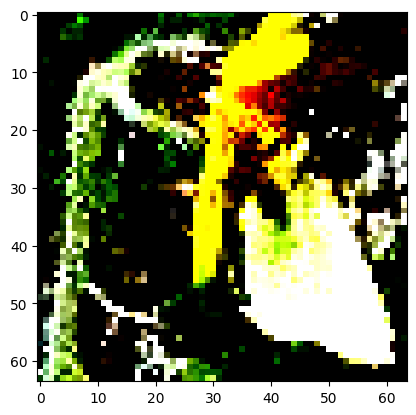

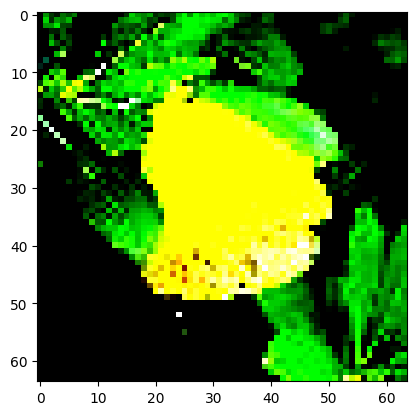

In [8]:
for batch in val_dataloader:
    images, class_nums = batch
    plt.imshow(images[5].permute(1, 2, 0))
    plt.show()
    plt.imshow(images[19].permute(1, 2, 0))
    plt.show()
    break

In [9]:
# class YourNet(torch.nn.Module): #first attemp
#     def __init__(self):
#         super().__init__()
#         self.conv1 = nn.Conv2d(3, 96, 11, 4)
#         self.relu1 = nn.ReLU()
#         self.pool1 = nn.MaxPool2d(3, 2)

#         self.conv2 = nn.Conv2d(96, 256, 5, padding=2)
#         self.relu2 = nn.ReLU()
#         self.pool2 = nn.MaxPool2d(3, 2)

#         self.conv3 = nn.Conv2d(256, 384, 3, padding=1)
#         self.relu3 = nn.ReLU()
#         self.conv4 = nn.Conv2d(384, 384, 3, padding=1)
#         self.relu4 = nn.ReLU()
#         self.conv5 = nn.Conv2d(384, 256, 3, padding=1)
#         self.relu5 = nn.ReLU()

#         self.pool3 = nn.MaxPool2d(3, 2)
#         self.flatten = nn.Flatten()

#         self.dense1 = nn.Linear(6400, 4096)
#         self.relu6 = nn.ReLU()
#         self.dropout1 = nn.Dropout()

#         self.dense2 = nn.Linear(4096, 4096)
#         self.relu7 = nn.ReLU()
#         self.dropout2 = nn.Dropout()

#         self.out = nn.Linear(4096, 200)

#     def _forward(self, x):
#         # runs the Neural Network
#         x = self.conv1(x)
#         x = self.relu1(x)
#         x = self.pool1(x)

#         x = self.conv2(x)
#         x = self.relu2(x)
#         x = self.pool2(x)

#         x = self.conv3(x)
#         x = self.relu3(x)
#         x = self.conv4(x)
#         x = self.relu4(x)
#         x = self.conv5(x)
#         x = self.relu5(x)

#         x = self.pool3(x)
#         x = self.flatten(x)

#         x = self.dense1(x)
#         x = self.relu6(x)
#         x = self.dropout1(x)

#         x = self.dense2(x)
#         x = self.relu7(x)
#         x = self.dropout2(x)

#         self.predictions = self.out(x)

#         return(self.predictions)

#     def forward(self, images, target=None):
#         self.target = target

#         return self._forward(images)

#     def get_accuracy(self, reset=False):
#         self.acc = accuracy(self.predictions, self.target, task='multiclass', num_classes=200)

#         return self.acc

### Тренировочный класс lightning

In [10]:
class YourModule(pl.LightningModule):
    def __init__(self, model, learning_rate):
        super().__init__()
        self.model = model
        self.lr = learning_rate
        self.max_acc = 0

    def forward(self, inputs):
        return self.model(inputs)

    def configure_optimizers(self):
        # return torch.optim.SGD(self.model.parameters(), lr=self.lr, momentum=0.9)
        return torch.optim.Adam(self.model.parameters(), lr=self.lr, weight_decay=1e-4)

    def training_step(self, train_batch, batch_idx):
        inputs, target = train_batch
        output = self(inputs)
        loss = torch.nn.functional.cross_entropy(output,target)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, val_batch, batch_idx):
        inputs, targets = val_batch
        output = self(inputs)
        acc = accuracy(torch.argmax(output, dim=1), targets, task='multiclass', num_classes=200)
        if acc > self.max_acc:
            self.max_acc = acc
            torch.save(model.state_dict(), 'best.pth')
        self.log('acc', acc)
        return acc

In [ ]:
wandb_logger = WandbLogger(log_model='all') # какие возможности дает с pytorch_lightning https://docs.wandb.ai/guides/integrations/lightning
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# model = YourNet().to(device)
model = torch.hub.load('pytorch/vision:v0.16.0', 'resnet18', pretrained=False)
model.load_state_dict(torch.load('/content/best_fine2.pth'))
model.to(device)
# model = model.fuse().autoshape()
module = YourModule(model, 1e-3)

In [ ]:
trainer = pl.Trainer(logger=wandb_logger,max_epochs=1)  # YOUR CODE HERE
trainer.fit(module, train_dataloader, val_dataloader)  # YOUR CODE HERE

### Валидация результатов задания

In [27]:
def evaluate_task(model, test_dataloader, device="cuda:0"):
    model = model.to(device)
    model.eval()
    acc = 0.0
    for images, labels in tqdm(test_dataloader):
        images, labels = images.to(device), labels.to(device)
        with torch.no_grad():
            output = model(images)
            acc_batch = accuracy(torch.argmax(output, dim=1), labels, task='multiclass', num_classes=200)
        acc += acc_batch
    acc = acc / len(test_dataloader)
    return acc

In [ ]:
model = torch.hub.load('pytorch/vision:v0.16.0', 'resnet18', pretrained=False)
model.load_state_dict(torch.load('best_fine2.pth'))

accur = evaluate_task(model, val_dataloader)
print(f"Оценка за это задание составит {np.clip(10 * accur.numpy() / 0.44, 0, 10):.2f} баллов")

In [ ]:
normalize = transforms.Normalize(
    mean=[0.4914, 0.4822, 0.4465],
    std=[0.2023, 0.1994, 0.2010]
)
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.05),
    transforms.ColorJitter(brightness=0.5),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    transforms.RandomRotation(degrees=45),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    normalize
])
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])

train_dataset = ImageFolder('/content/dataset/dataset/train', transform=train_transform)
val_dataset = ImageFolder('/content/dataset/dataset/val', transform=val_transform)
# REPLACE ./dataset/dataset WITH THE FOLDER WHERE YOU DOWNLOADED AND UNZIPPED THE DATASET

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True, num_workers=os.cpu_count()) # YOUR CODE HERE
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, drop_last=True, num_workers=os.cpu_count()) # YOUR CODE HERE

### Тренировочный класс lightning

In [ ]:
class YourModule(pl.LightningModule):
    def __init__(self, model, learning_rate):
        super().__init__()
        self.model = model
        self.lr = learning_rate
        self.max_acc = 0

    def forward(self, inputs):
        return self.model(inputs)

    def configure_optimizers(self):
        # return torch.optim.SGD(self.model.parameters(), lr=self.lr, momentum=0.9)
        # return torch.optim.Adam(self.model.parameters(), lr=self.lr, weight_decay=1e-4)j
        return torch.optim.Adamax(self.model.parameters(), lr=self.lr, weight_decay=1e-4)

    def training_step(self, train_batch, batch_idx):
        inputs, target = train_batch
        output = self(inputs)
        loss = torch.nn.functional.cross_entropy(output,target)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, val_batch, batch_idx):
        inputs, targets = val_batch
        output = self(inputs)
        acc = accuracy(torch.argmax(output, dim=1), targets, task='multiclass', num_classes=200)
        if acc > self.max_acc:
            self.max_acc = acc
            torch.save(model.state_dict(), 'best_pretrained.pth')
        self.log('acc', acc)
        return acc

In [ ]:
wandb_logger = WandbLogger(log_model='all') # какие возможности дает с pytorch_lightning https://docs.wandb.ai/guides/integrations/lightning
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# model = YourNet().to(device)j
model = models.mobilenet_v3_large(pretrained=True).to(device)
module = YourModule(model, 1e-3)

In [ ]:
trainer = pl.Trainer(logger=wandb_logger,max_epochs=40)
trainer.fit(module, train_dataloader, val_dataloader)

### Валидация результатов

In [ ]:
model = torch.vision.models.mobilenet_v3(pretrained=True).to(device)

accuracy = evaluate_task(model, val_dataloader)
print(f"Оценка за это задание составит {np.clip(10 * (accuracy - 0.5) / 0.34, 0, 10):.2f} баллов")